# Boosting and Classification

Data: The data we will use has been taken from here: https://archive.ics.uci.edu/ml/datasets/Adult.

There will be some basic preprocessing work to do, some of which is outlined. But please post on Canvas as questions arise. The goal of this homework is to take census data and predict whether an individual would have an income that exceeds $50k/yr. This is a binary classification problem.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, style
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

# 1. Data Processing
a) Import the data from the website directly: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [2]:
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)
adult_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_df.dtypes

0      int64
1     object
2      int64
3     object
4      int64
5     object
6     object
7     object
8     object
9     object
10     int64
11     int64
12     int64
13    object
14    object
dtype: object

b) There is no header included, but information on column names is here: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names.

Scroll to the bottom of that link to see the explanation of the columns. You need to build the column names for your dataframe. It is highly encouraged to not include spaces in column names. Finally, call your target variable (the last column of ">50K" or "<=50k") `salary`.

In [4]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race",
           "sex", "capital_gain", "capital_loss", "hours_per_week", 
           "native_country", "salary"] 
adult_df.columns = columns
adult_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


c) Check your dataframe shape to verify that you have the correct number of rows and columns. You should get a shape of: `(32561, 15)`.

In [5]:
adult_df.shape

(32561, 15)

d) Drop the 3rd column from the data (it is referred to as `fnlwgt` on UCI's website and is not necessary in this homework)

In [6]:
adult_df.drop(["fnlwgt"], axis=1, inplace=True)

e) Note: There are random values of "?" that show up in the data - this is fine! These just refer to "unknown" and can be left as is. This data has no true NA values, so no need to check.

f) Use the `.replace()` method to make the following changes to the `salary` column:

* "<=50K" should become 0

* ">50K" should become 1

Note: This step is essential to calculate the `ROC_AUC` score in model evaluation steps.

In [7]:
adult_df.salary.replace(adult_df.salary.unique()[0], 0, inplace=True)

In [8]:
adult_df.salary.replace(adult_df.salary.unique()[1], 1, inplace=True)

g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is `salary`.

In [9]:
X = adult_df.drop(["salary"], axis=1)
y = adult_df.salary

 i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use __Pandas__ built-in method `.get_dummies()`. Pandas will automatically split out columns that are categorical. For now, just run across your full `X` dataframe.

In [10]:
X_encoded = pd.get_dummies(X)

Your updated `X` dataframe should have the following shape: `(32561, 107)`.

In [11]:
X_encoded.shape

(32561, 107)

j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your `X_train` and `X_test`.

In [12]:
X_train, X_test = train_test_split(X_encoded, test_size=.30, random_state=0)
y_train, y_test = train_test_split(y, test_size=.30, random_state=0)

In [13]:
X_train.shape[1] == X_test.shape[1]

True

In [14]:
y_train.value_counts()

0    17313
1     5479
Name: salary, dtype: int64

# 2. Random Forest Classifier - Base Model
Start by creating a simple Random Forest only using default parameters - this will let us compare Boosting methods to Random Forest in binary classification problems.

a) Use the `RandomForestClassifier` in __sklearn__. Fit your model on the training data.

In [15]:
rf_mod_base = RandomForestClassifier().fit(X_train, y_train)

b) Use the fitted model to predict on test data. Use the `.predict_proba()` and the `.predict()` methods to get predicted probabilities as well as predicted classes.

In [16]:
y_test_pred = rf_mod_base.predict(X_test)

# limit to probability for class = 1
rf_mod_base_probs = rf_mod_base.predict_proba(X_test)[:, 1]

c) Calculate the confusion matrix and classification report (both are in `sklearn.metrics`).

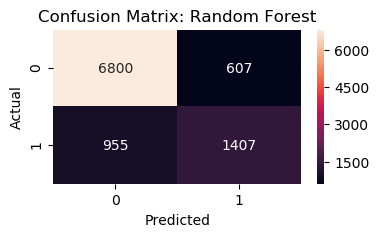

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7407
           1       0.70      0.60      0.64      2362

   micro avg       0.84      0.84      0.84      9769
   macro avg       0.79      0.76      0.77      9769
weighted avg       0.83      0.84      0.84      9769



In [17]:
labels_df = adult_df.loc[:, adult_df.columns == "salary"]
labels = labels_df.drop_duplicates().sort_values("salary")

conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: Random Forest")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred))

d) Calculate the AUC score (we did this in HW \#4 many times)

In [18]:
print("ROC: {}".format(metrics.roc_auc_score(y_test, rf_mod_base_probs)))

ROC: 0.8708718850408916


e) Identify the top 5 features. Feel free to print a list OR to make a plot.

name                                   score
age                                0.236328
hours_per_week                     0.114319
capital_gain                       0.0980331
marital_status_Married-civ-spouse  0.0686087
education_num                      0.0671963


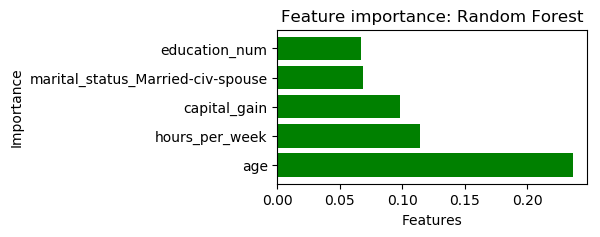

In [19]:
importances = rf_mod_base.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_mod_base.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values_rf = sorted(zip(X_test.columns, importances), key=lambda x: x[1] * -1)
print(tabulate(values_rf[0:5], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Feature importance: Random Forest")
plt.barh(pd.DataFrame(values_rf[0:5]).iloc[:, 0], importances[indices][0:5],
       color="g", align="center")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

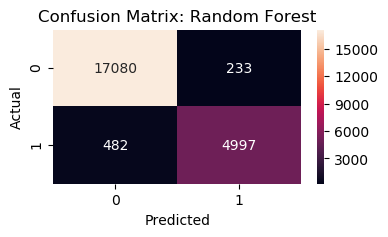

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17313
           1       0.96      0.91      0.93      5479

   micro avg       0.97      0.97      0.97     22792
   macro avg       0.96      0.95      0.96     22792
weighted avg       0.97      0.97      0.97     22792



In [20]:
y_train_pred = rf_mod_base.predict(X_train)

# limit to probability for class = 1
rf_mod_base_probs = rf_mod_base.predict_proba(X_train)[:, 1]

conf_mat = metrics.confusion_matrix(y_true=y_train,
                                    y_pred=y_train_pred)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: Random Forest")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_train, y_train_pred))

The model is overfitting. There is a sizable difference between train/test precision, recall, and f1-score.

# 3. AdaBoost Classifier - GridSearch:

Start by creating a simple `AdaBoostClassifier` only using default parameters.

Note: __sklearn__ defaults to a max_depth of 1 for AdaBoost. Read more in the documentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html.

a) Use the `AdaBoostClassifier` along with the `GridSearchCV` tool. Run the `GridSearchCV` using the following:

* `n_estimators`: 100, 200, 300, 400

* `learning_rate`: 0.2,0.4,0.6,0.8,1, 1.2

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and for scoring use `roc_auc` (this is the score that will be referenced when identifying the best parameters).

In [21]:
# create a dictionary of parameters
param_grid = {"n_estimators": [100, 200, 300, 400], "learning_rate": [0.2,0.4,0.6,0.8,1, 1.2],
              "random_state": [0]}

# create random forest model
ada_obj = AdaBoostClassifier()

# Create gridsearch object with various combinations of parameters
ada_grid = GridSearchCV(ada_obj, param_grid, cv=5, scoring="roc_auc", refit=True, n_jobs=-1, verbose=0)

In [22]:
%%time
ada_grid_fit = ada_grid.fit(X_train, y_train)

CPU times: user 4.82 s, sys: 500 ms, total: 5.32 s
Wall time: 1min 52s


b) Use the best estimator from `GridSearchCV` to predict on test data. Use the `.predict_proba()` and the .predict() methods to get predicted probabilities as well as predicted classes.

In [23]:
ada_best_model = ada_grid_fit.best_estimator_
ada_linear_best_params = ada_grid_fit.best_params_
ada_linear_best_params

y_test_pred_grid = ada_best_model.predict(X_test)

# limit to probability for class = 1
ada_best_mod_probs = ada_best_model.predict_proba(X_test)[:, 1]

c) Calculate the confusion matrix and classification report.

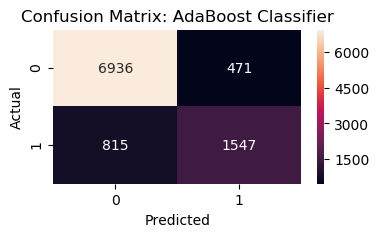

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7407
           1       0.77      0.65      0.71      2362

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.86      0.87      0.86      9769



In [24]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred_grid)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: AdaBoost Classifier")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred_grid))

d) Calculate the AUC core

In [25]:
print("ROC: {}".format(metrics.roc_auc_score(y_test, y_test_pred_grid)))

ROC: 0.7956824659649253


e) Identify the top 5 features.

name                score
capital_gain    0.396667
capital_loss    0.233333
age             0.0933333
hours_per_week  0.0333333
education_num   0.02


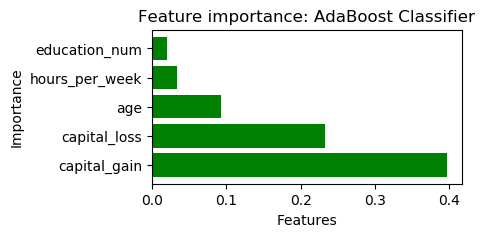

In [26]:
importances = ada_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in ada_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values_ada = sorted(zip(X_test.columns, importances), key=lambda x: x[1] * -1)
print(tabulate(values_ada[0:5], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Feature importance: AdaBoost Classifier")
plt.barh(pd.DataFrame(values_ada[0:5]).iloc[:, 0], importances[indices][0:5],
       color="g", align="center")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

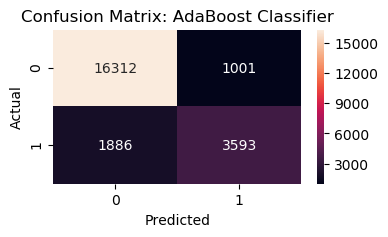

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17313
           1       0.78      0.66      0.71      5479

   micro avg       0.87      0.87      0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792



In [27]:
y_train_pred = ada_best_model.predict(X_train)

# limit to probability for class = 1
rf_mod_base_probs = ada_best_model.predict_proba(X_train)[:, 1]

conf_mat = metrics.confusion_matrix(y_true=y_train,
                                    y_pred=y_train_pred)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: AdaBoost Classifier")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_train, y_train_pred))

Results are stable between train/test. Ada Boost has a much smaller generalization error than Random Forest, so overfitting is not an issue here.

# 4. Gradient Boosting Classifier - GridSearch:

a) Use `GradientBoostingClassifier` along with the `GridSearchCV` tool. Run the `GridSearchCV` using the following hyperparameters:

* `n_estimators`: 100, 200, 300, 400

* `learning_rate`: choose 3 learning rates of your choice

* `max_depth`: 1, 2 (you can try deeper, but remember part of the value of boosting stems from minimal complexity of trees)

Use 5 cross-fold and for scoring use `roc_auc` (this is the score that will be referenced when identifying the best parameters).

In [28]:
# create a dictionary of parameters
param_grid = {"n_estimators": [100, 200, 300, 400], "learning_rate": [.001, .01, .1],
              "max_depth": [1, 2, 3], "random_state": [0]}

# create random forest model
gbc_obj = GradientBoostingClassifier()

# Create gridsearch object with various combinations of parameters
gbc_grid = GridSearchCV(gbc_obj, param_grid, cv=5, scoring="roc_auc", refit=True, n_jobs=-1, verbose=0)

In [29]:
%%time
gbc_grid_fit = gbc_grid.fit(X_train, y_train)

CPU times: user 20.2 s, sys: 808 ms, total: 21 s
Wall time: 5min


b) Use the best estimator from `GridSearchCV` to predict on test data. Use the `.predict_proba()` and the .predict() methods to get predicted probabilities as well as predicted classes.

In [40]:
gbc_best_model = gbc_grid.best_estimator_
gbc_linear_best_params = gbc_grid.best_params_
gbc_linear_best_params

y_test_pred_grid = gbc_best_model.predict(X_test)

# limit to probability for class = 1
gbc_best_mod_probs = gbc_best_model.predict_proba(X_test)[:, 1]

c) Calculate the confusion matrix and classification report.

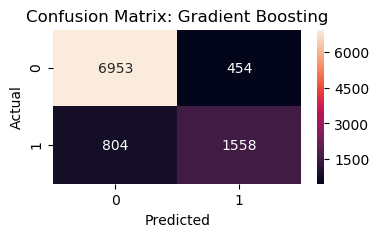

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7407
           1       0.77      0.66      0.71      2362

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [31]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred_grid)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: Gradient Boosting")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred_grid))

d) Calculate the AUC score.

In [32]:
print("ROC: {}".format(metrics.roc_auc_score(y_test, y_test_pred_grid)))

ROC: 0.7991585642206088


e) Identify the top 5 features.

name                                   score
marital_status_Married-civ-spouse  0.361803
capital_gain                       0.197178
education_num                      0.18501
age                                0.063752
capital_loss                       0.0610591


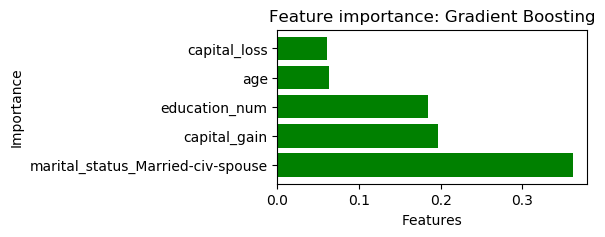

In [33]:
importances = gbc_best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values_gbc = sorted(zip(X_test.columns, importances), key=lambda x: x[1] * -1)
print(tabulate(values_gbc[0:5], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Feature importance: Gradient Boosting")
plt.barh(pd.DataFrame(values_gbc[0:5]).iloc[:, 0], importances[indices][0:5],
       color="g", align="center")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

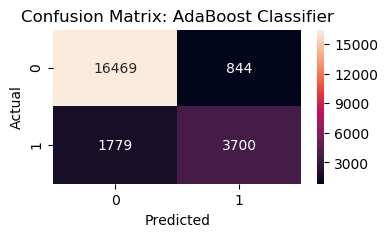

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     17313
           1       0.81      0.68      0.74      5479

   micro avg       0.88      0.88      0.88     22792
   macro avg       0.86      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



In [34]:
y_train_pred = gbc_best_model.predict(X_train)

# limit to probability for class = 1
rf_mod_base_probs = gbc_best_model.predict_proba(X_train)[:, 1]

conf_mat = metrics.confusion_matrix(y_true=y_train,
                                    y_pred=y_train_pred)
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.title("Confusion Matrix: AdaBoost Classifier")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["salary"],
            yticklabels=labels["salary"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_train, y_train_pred))

Gradient Boosting had a small generalization error of approximately 1% (similar to Adaboost) across scoring metrics (precision, recall, f1-score).

# Moving into Conceptual Problems:

5) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling. 

The $\alpha$ parameter represents the weight of the predictors. Initially, $\alpha$ is the same for all. But as the alogirthm iterates, the weights are increased for missclassification. 

6) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation. 

Adaboost, short for Adaptive Boosting, is a boosting algorithm that reaches its final prediction by ensembling a sequence of classifiers whom are weak in isolation, but greater as a whole. Distinctive to other algorithms, Adaboost responds to misclassifications by "boosting" the relative weights ($\alpha$) where the initial classifier underfit the data. Subsequently, additional classifiers are fit with the new weights. This process is done iteratively until convergence. The idea essentially is that classifiers further in the sequence will focus on the difficult data.

We can imagine the process of Adaboost and how it could be potentially suspectible to noise and outliers, due to the algorithm's propensity to focuse on misclassification. Proper use of $\lambda$ (learning rate), by setting it relatively low in the context of the data, can help prevent overfitting as the algorithm. In this light, the algorithm learns at a slower rate and will be resistant to finding the fastest path to fitting the data (overfitting). The latter situation results in strong training performance, but the generalization error will be high. 

7) In Gradient Boosting, what is the role of the `max_depth` parameter? Why is it important to tune on this parameter?

`max_depth` represents the number of nodes in a tree, and thus controls for complexity. Higher complexity can result in overfitting, since it allows the algorithm to find additional patterns in the data; however, these patterns may not generalize well.

8) In Part (e) of Steps 2-4 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

In [35]:
pd.concat([pd.DataFrame(values_rf[0:5], columns=["var", "importances"]).assign(model = "rf"), 
           pd.DataFrame(values_ada[0:5], columns=["var", "importances"]).assign(model = "ada"), 
           pd.DataFrame(values_gbc[0:5], columns=["var", "importances"]).assign(model = "gbc")],axis=1)

,var,importances,model,var,importances,model,var,importances,model
0,age,0.236328,rf,capital_gain,0.396667,ada,marital_status_Married-civ-spouse,0.361803,gbc
1,hours_per_week,0.114319,rf,capital_loss,0.233333,ada,capital_gain,0.197178,gbc
2,capital_gain,0.098033,rf,age,0.093333,ada,education_num,0.185010,gbc
3,marital_status_Married-civ-spouse,0.068609,rf,hours_per_week,0.033333,ada,age,0.063752,gbc
4,education_num,0.067196,rf,education_num,0.020000,ada,capital_loss,0.061059,gbc


`age`, `capital_gain`, and `education_num` are ranked in the top 5 for variable importance in all three models. These are intuitive, as age and education level are both good common-sense heuristics for prediction income. Additionally, wealthy individuals (or in this case, people who make $50k+ a year) tend to own investment securities that would result in capital gains.

9) From the models run in steps 2-4, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

It is difficult to declare a winner. Adaboost and Gradient Boosting both performed nearly identical in holdout and train, with generalization errors of about 1%. The best parameters for each model are below. Note that the models diverged in choice of learning rate: Adaboost performed better with 1.2, while Gradient Descent Boosting settled on 0.1.

In [36]:
ada_best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=300, random_state=0)

In [37]:
gbc_best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

10) For your best performing model, plot out an ROC curve using your test data. Feel free to use __sklearn__, __matplotlib__ or any other method in python.

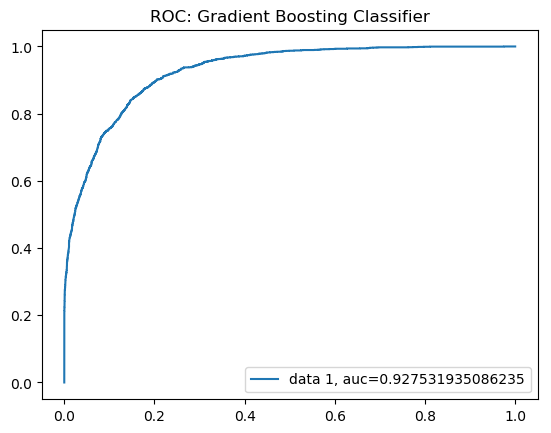

In [44]:
fpr, tpr, _ = metrics.roc_curve(y_test,  gbc_best_mod_probs)
auc = metrics.roc_auc_score(y_test, gbc_best_mod_probs)
plt.title("ROC: Gradient Boosting Classifier")
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()